# The Portfolio

In [11]:
import pandas as pd
from typing import Callable

from tqdm import tqdm

from backtesting import Portfolio

First of all we create a Portfolio. This needs to identify which would be the currency that will held the liquidity, as well as the commissions to transfer liquidity into the portfolio (deposit or withdrawal) and the commissions for trading.

In [12]:
MyPortfolio = Portfolio(
                    symbol='USDT',
                    commission_trade=0.0001,
                    commission_transfer=0.001
)

To deposit some initial funds, we need to use the deposit method. This method takes two arguments: the amount to deposit and the date of the deposit. The date of the deposit is optional and defaults to the current date.

In [13]:
MyPortfolio.deposit(amount=100_000, timestamp=pd.Timestamp('2020-01-01 00:00:00'))

KeyError: "['USDT'] not found in axis"

To update the prices, we use the method update_prices() of the Portfolio object. This method requires a dictionary with the prices of the assets in the portfolio. The keys of the dictionary are the symbols of the assets and the values are the prices. If the asset already exists it will be updated, if not, it will be created and updated. A timestamp can also be provided, but in case of not providing it, it would take the current time.

In [ ]:
MyPortfolio.update_prices(prices={'BTC': 10_000, 'ETH': 1_000, 'LTC': 100}, timestamp=pd.Timestamp('2020-01-01 00:00:01'))

To buy some assets, it's need to call the method buy(). This requires to define the symbol, the asset's amount and the timestamp of the transaction. The amount is in the base currency of the portfolio. A timestamp can also be provided, but in case of not providing it, it would take the current time.

In [ ]:
MyPortfolio.buy(symbol='BTC', amount_quote=20, timestamp=pd.Timestamp('2020-01-01 00:00:02'))

In [ ]:
MyPortfolio.update_prices(prices={'BTC': 20_000, 'ETH': 2_000, 'LTC': 200}, timestamp=pd.Timestamp('2020-01-02 00:00:01'))

The assets can also be sold at some point. This is done with the sell method. The amount of the asset to be sold is specified in the base currency. The timestamp of the transaction can also be provided.

In [ ]:
MyPortfolio.sell(symbol='BTC', amount_quote=20, timestamp=pd.Timestamp('2020-01-02 00:00:02'))

In [ ]:
MyPortfolio.sell(symbol='BTC', amount_quote=20, timestamp=pd.Timestamp('2020-01-02 00:00:02'))

In [ ]:
MyPortfolio.plot_benchmark()

In [ ]:
MyPortfolio.withdraw(amount=1, relative_amount=True, timestamp=pd.Timestamp('2020-01-02 00:00:03'))

In [1]:
from dataclasses import dataclass
import pickle
from typing import Optional, Literal, Union, Callable

import numpy as np
import pandas as pd
from tqdm import tqdm

from backtesting import Portfolio

@dataclass
class Strategy:
    """
    Dataclass defining the basic structure of a strategy.

    """

    name: str
    initial_equity: float
    historical_prices: dict[str, pd.DataFrame]
    commission_trade: float = 0.00075
    commission_transfer: float = 0.0
    portfolio_symbol: str = "USDT"
    description: Optional['str'] = None

    def __post_init__(self):
        self.create_historical_prices_df()
        self.Portfolios_list = []
        self.assets_symbols_list = list(self.historical_prices.keys())
        self.current_timestamp = self.initial_timestamp
    
    def create_historical_prices_df(self) -> None:
        """
        Convert the historical prices dictionary to a DataFrame.

        """
        dfs = []
        for symbol, df in self.historical_prices.items():
            col = df.columns[0]
            df.rename(columns={col: symbol}, inplace=True)
            dfs.append(df)
        merged_df = dfs[0]
        if len(dfs) > 1:
            for df in dfs[1:]:
                merged_df = pd.merge(merged_df, df, how='outer', left_index=True, right_index=True)
        self.historical_prices_df = merged_df
    
    @property
    def random_asset_distribution_weights(self) -> np.ndarray:
        """
        Generate random weights for the assets in the strategy.

        """
        decimals = 4
        weights = np.random.random(len(self.assets_symbols_list) + 1)
        weights_norm = weights / np.sum(weights)
        # The last value is the cash weight, so we don't include it.
        weights_assets = weights_norm[:-1]
        weights_assets_rounded = np.around(weights_assets, decimals)
        return weights_assets_rounded

    @property
    def initial_timestamp(self) -> pd.Timestamp:
        """
        Get the initial timestamp of the strategy.

        """
        return self.historical_prices_df.index[0]
    
    def increase_timestamp(self) -> None:
        """
        Increase the timestamp pointer to the next timestamp.

        """
        current_timestamp = self.current_timestamp
        current_idx = self.historical_prices_df.index.get_loc(current_timestamp)
        if current_idx < len(self.historical_prices_df.index) - 1:
            next_idx = current_idx + 1
            next_timestamp = self.historical_prices_df.index[next_idx]
            self.current_timestamp = next_timestamp
        else:
            self.current_timestamp = None
    
    @property
    def next_timestamp(self) -> pd.Timestamp:
        """
        Get the next timestamp of the strategy.

        """
        current_timestamp = self.current_timestamp
        current_idx = self.historical_prices_df.index.get_loc(current_timestamp)
        if current_idx < len(self.historical_prices_df.index) - 1:
            next_idx = current_idx + 1
            next_timestamp = self.historical_prices_df.index[next_idx]
            return next_timestamp
        else:
            return None
    
    def get_prices_on_timestamp(self, timestamp: int) -> dict[str, float]:
        """
        Get the prices of the assets in the strategy on a specific timestamp.

        """
        return self.historical_prices_df.loc[timestamp].to_dict()
    
    def buy_random_asset(self, portfolio: Portfolio) -> None:
        """
        Buy a random asset in the portfolio.

        """
        random_weights = self.random_asset_distribution_weights
        initial_balance = portfolio.balance
        initial_timestamp = self.initial_timestamp
        prices = self.get_prices_on_timestamp(initial_timestamp)
        portfolio.update_prices(prices=prices, timestamp=initial_timestamp)
        for asset, weight in zip(self.assets_symbols_list, random_weights):
            amount_quote = initial_balance * weight
            portfolio.buy(symbol=asset, amount_quote=amount_quote, timestamp=initial_timestamp)

    def create_random_single_portfolio(self) -> None:
        """
        Create a Portfolio object based on the strategy's attributes.

        Returns:
            Portfolio: Portfolio object.

        """
        PF = Portfolio(
            symbol=self.portfolio_symbol,
            commission_trade=self.commission_trade,
            commission_transfer=self.commission_transfer
        )
        PF.set_verbosity(type='silent')
        PF.deposit(amount=self.initial_equity, timestamp=self.initial_timestamp)
        self.buy_random_asset(PF)
        previous_amount_factor = {asset: 0 for asset in PF.assets_list}
        PF.previous_amount_factor = previous_amount_factor
        self.Portfolios_list.append(PF)

    
    def create_random_portfolios(self, n: int):
        """
        Create multiple Portfolio objects based on the strategy's attributes.

        """
        for _ in range(n):
            self.create_random_single_portfolio()
    
    def update_prices(self) -> None:
        """
        Update the prices of the assets in the strategy until the current timestamp.

        """
        prices = self.get_prices_on_timestamp(self.current_timestamp)
        for PF in self.Portfolios_list:
            PF.update_prices(prices=prices, timestamp=self.current_timestamp)
    
    
    def create_signals_df(self, func:Callable, *args, **kwargs) -> pd.DataFrame:
        """
        Create a signal DataFrame based on a signal function.

        """
        df = self.historical_prices_df
        output_df = func(df, *args, **kwargs)
        self.signals_df = output_df
    
    @property
    def get_known_prices(self) -> pd.DataFrame:
        """
        Get the prices of the assets in the strategy until the current timestamp.

        """
        return self.historical_prices_df.loc[:self.current_timestamp]
    
    @property
    def get_known_signals(self) -> pd.DataFrame:
        """
        Get the signals of the assets in the strategy until the current timestamp.

        """
        return self.signals_df.loc[:self.current_timestamp]    
    
    @property
    def current_signals(self) -> pd.DataFrame:
        """
        Apply a signal function to a DataFrame.

        """
        output_df = self.get_known_signals.iloc[-1]
        sell_df = output_df < -0.05
        buy_df = output_df > 0.008
        return pd.DataFrame({ 'value': output_df, 'sell': sell_df, 'buy': buy_df})
    
    def trade_on_signals(self, func:Callable, *args, **kwargs) -> None:
        """
        Apply a signal function to the strategy's Portfolios.

        """
        amount = 50 # USDT
        minimal_balance = amount * 2
        signals = self.current_signals
        for PF in self.Portfolios_list:
            # To have liquidity, we sell the asset with the lowest value.
            if PF.liquidity_ratio < 0.02:
                desired_liquidity_ratio = 0.1
                desired_liquidity = desired_liquidity_ratio * PF.equity_value
                # We rank the assets by performance.
                lowest_perfo_asset_ranking = signals['value'].sort_values().index
                # However, we keep the asset with the highest value.
                # We allow having low liquidity if everything is invested on the highest value asset.
                for asset in lowest_perfo_asset_ranking[:-1]:
                    # We sell the asset with the lowest performance that has a value higher than the amount.
                    asset_value = PF.get_value(symbol=asset, quote='USDT')
                    asset_value_ = np.floor(asset_value)
                    desired_liquidity_ = np.floor(desired_liquidity)
                    if (asset_value_ > 0) & (desired_liquidity_ > 0):
                        if asset_value_ < desired_liquidity_:
                            PF.sell(symbol=asset, amount_quote=asset_value_, timestamp=self.current_timestamp)
                            desired_liquidity -= asset_value
                        else:
                            # print(f"Asset:{asset}, Value:{asset_value}/{asset_value_}, Desired Liquidity:{desired_liquidity}/{desired_liquidity_}")
                            PF.sell(symbol=asset, amount_quote=desired_liquidity_, timestamp=self.current_timestamp)
                            break
                    # if PF.get_value(symbol=asset, quote='USDT') > amount:
                    #     PF.sell(symbol=asset, amount_quote=amount, timestamp=self.current_timestamp)
                    #     # We break the loop to avoid selling multiple assets.
                    #     break
            for asset, signal in signals.iterrows():
                factor = PF.previous_amount_factor[asset]
                if signal['buy']:
                    balance_ = PF.balance / (1 + PF.commission_trade)
                    if balance_ > minimal_balance:
                        if factor <= 0:
                            factor = 1
                        else:
                            factor += 1
                        factor_amount = amount * factor
                        if (balance_ - minimal_balance) > factor_amount:
                            factor_amount_ = np.floor(factor_amount)
                            PF.buy(symbol=asset, amount_quote=factor_amount_, timestamp=self.current_timestamp)
                            PF.previous_amount_factor[asset] = factor
                        elif (balance_ - minimal_balance) > amount:
                            amount_ = np.floor(amount)
                            PF.buy(symbol=asset, amount_quote=amount_, timestamp=self.current_timestamp)
                            PF.previous_amount_factor[asset] = factor - 1
                elif signal['sell']:
                    factor = PF.previous_amount_factor[asset]
                    if factor >= 0:
                        factor = -1
                    else:
                        factor += -1
                    factor_amount = amount * abs(factor)
                    if PF.get_value(symbol=asset, quote='USDT') > factor_amount:
                        factor_amount_ = np.floor(factor_amount)
                        PF.sell(symbol=asset, amount_quote=factor_amount_, timestamp=self.current_timestamp)
                        PF.previous_amount_factor[asset] = factor
                    elif PF.get_value(symbol=asset, quote='USDT') > amount:
                        amount_ = np.floor(amount)
                        PF.sell(symbol=asset, amount_quote=amount_, timestamp=self.current_timestamp)
                        PF.previous_amount_factor[asset] = factor + 1
                else:
                        PF.previous_amount_factor[asset] = 0

        
    def run_strategy(self, signal_function: Callable, *args, **kwargs) -> None:
        """
        Run the strategy.

        """
        # The first timestamp is the initial timestamp.
        self.create_signals_df(signal_function, *args, **kwargs)
        self.increase_timestamp()
        length_batch = len(self.historical_prices_df)
        with tqdm(total=length_batch, position=0, leave=True) as pbar:
            pbar.update(1)
            while self.current_timestamp is not None:
                self.update_prices()
                self.trade_on_signals(signal_function, *args, **kwargs)
                self.increase_timestamp()
                pbar.update(1)

In [2]:
with open('./data/prices.pkl', 'rb') as file:
    historical_prices = pickle.load(file)

MyStrategy = Strategy(name='Random', initial_equity=10_000, historical_prices=historical_prices)

In [3]:
MyStrategy.create_random_portfolios(n=1)
MyStrategy.Portfolios_list

[Portfolio (christy_roberts):
   -> Symbol = USDT
   -> Transfer commission = 0.00%
   -> Trade commission = 0.075%
   -> Invested capital = 10,000.00 USDT
   -> Disbursed capital = 0.00 USDT
   -> Quote balance = 1,974.99 USDT
   -> Assets value = 8,019.00 USDT
   -> Equity value = 9,993.99 USDT
   -> Transactions = 6
   -> Total traded = 8,019.00 USDT
   -> Gains = -6.01 USDT
   -> Total commissions = 6.01 USDT
   -> Commission gains ratio = N/A
   -> ROI = -0.06%
   -> Hold Gains (Theoretical) = -6.01 USDT
   -> Hold ROI (Theoretical) = -0.06%
   -> ROI Performance (vs Hold) = 0.00%
   -> Assets:
       +--------+--------------+---------------+----------------+--------------+---------------+-----------------+------------+
       | Symbol |      Balance |         Value |          Price | Transactions |  Total traded | Currency growth | Hold gains |
       +--------+--------------+---------------+----------------+--------------+---------------+-----------------+------------+
       | 

In [4]:
def macd_func(df: pd.DataFrame, window_factor: int = 1) -> pd.DataFrame:
    """
    Calculate the moving average of a DataFrame.

    """
    win12 = window_factor * 12
    win26 = window_factor * 26
    ma12 = df.rolling(window=win12).mean()
    ma26 = df.rolling(window=win26).mean()
    ma12_norm = ma12 / df
    ma26_norm = ma26 / df
    macd = ma12_norm - ma26_norm
    return macd.fillna(0)

In [5]:
MyStrategy.run_strategy(signal_function=macd_func, window_factor=10)

100%|██████████| 43200/43200 [00:09<00:00, 4424.56it/s]


In [6]:
MyStrategy.Portfolios_list

[Portfolio (christy_roberts):
   -> Symbol = USDT
   -> Transfer commission = 0.00%
   -> Trade commission = 0.075%
   -> Invested capital = 10,000.00 USDT
   -> Disbursed capital = 0.00 USDT
   -> Quote balance = 1,202.99 USDT
   -> Assets value = 9,421.46 USDT
   -> Equity value = 10,624.45 USDT
   -> Transactions = 949
   -> Total traded = 232,015.00 USDT
   -> Gains = 624.45 USDT
   -> Total commissions = 174.01 USDT
   -> Commission gains ratio = 27.87%
   -> ROI = 6.24%
   -> Hold Gains (Theoretical) = 470.10 USDT
   -> Hold ROI (Theoretical) = 4.70%
   -> ROI Performance (vs Hold) = 1.54%
   -> Assets:
       +--------+--------------+---------------+----------------+--------------+-----------------+-----------------+-------------+
       | Symbol |      Balance |         Value |          Price | Transactions |    Total traded | Currency growth |  Hold gains |
       +--------+--------------+---------------+----------------+--------------+-----------------+-----------------+-----

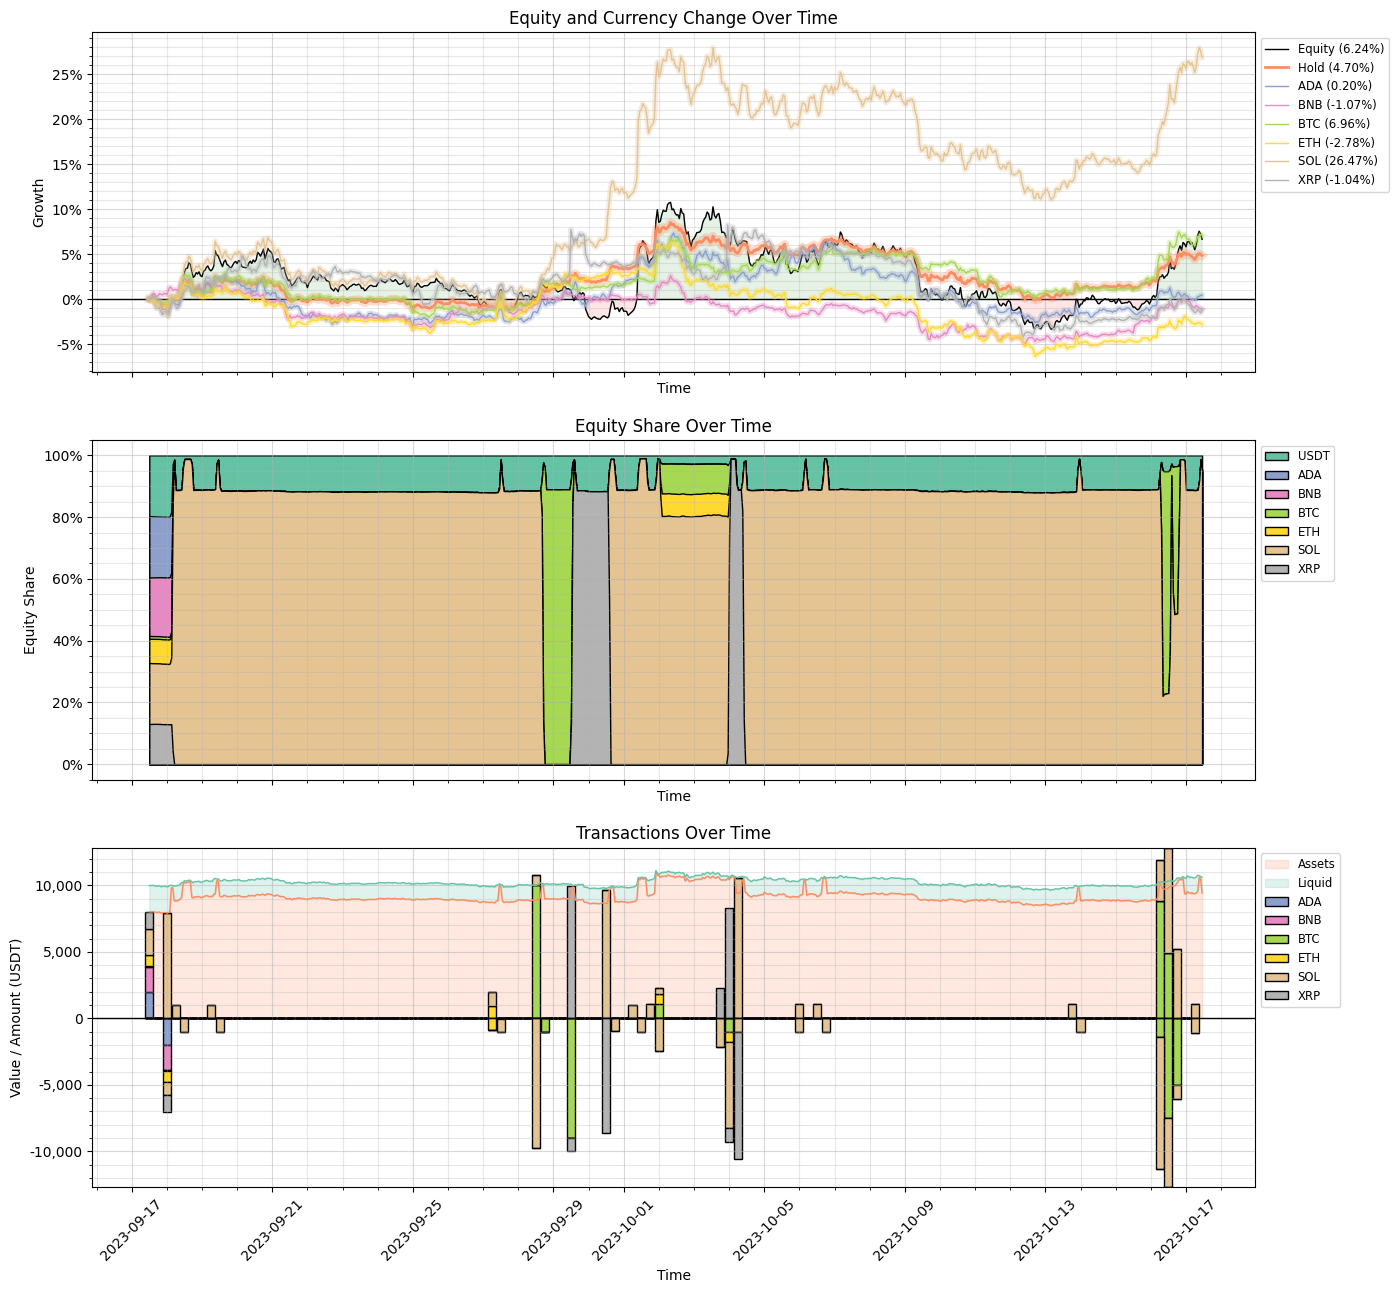

In [7]:
MyStrategy.Portfolios_list[0].plot_summary()